In [9]:
import numpy as np
import sympy as sp
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import itertools
import nengo
from nengo.processes import Piecewise

In [167]:
def plot_phase_portrait(f, ax=None, figsize=(3, 3), symbolic_eqilibria=True, th=1e-3):
    xs = np.linspace(-2, 2, 11)
    us = np.linspace(-2, 2, 11)

    xss, uss = np.meshgrid(xs, us)
    dxss, duss = f(xss, uss)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    # Plot the quiver plot
    ax.quiver(xss, uss, dxss, duss)

    # Try to plot the equilibria
    if symbolic_eqilibria:
        # Create some sympy symbols
        x, u = sp.symbols('x u')

        # Compute the Jacobian elements
        dfx_dx = sp.diff(f(x, u)[0], x)
        dfx_du = sp.diff(f(x, u)[0], u)
        dfu_dx = sp.diff(f(x, u)[1], x)
        dfu_du = sp.diff(f(x, u)[1], u)

        # Plot the equilibria
        xs = np.linspace(-2, 2, 100)
        us = np.linspace(-2, 2, 100)

        sols_dict = sp.solve(f(x, u), (x, u))
        if not isinstance(sols_dict, dict):
            sols_dict = {}
            for var_ in (x, u):
                sol = sp.solve(f(x, u), var_)
                if len(sol) > 0:
                    if isinstance(sol, dict):
                        sols_dict[var_] = sol[var_]
                    else:
                        sols_dict[var_] = list(itertools.chain.from_iterable(sol))

        for var_, sols in sols_dict.items():
            if not hasattr(sols, '__iter__'):
                sols = [sols]
            for sol in sols:
                if var_ is x:
                    f_sol = sp.utilities.lambdify(u, sol, "numpy")
                    f_xs = f_sol(us) * np.ones_like(us)
                    f_us = us
                elif var_ is u:
                    f_sol = sp.utilities.lambdify(x, sol, "numpy")
                    f_us = f_sol(xs) * np.ones_like(xs)
                    f_xs = xs
                else:
                    raise ValueError("Unknown variable")

                # Differentiate between stable and unstable attractors
                f_us_stable, f_xs_stable = np.copy(f_us), np.copy(f_xs)
                f_us_unstable, f_xs_unstable = np.copy(f_us), np.copy(f_xs)

                for i, (uv, xv) in enumerate(zip(f_us, f_xs)):
                    if np.isnan(uv) or np.isnan(xv):
                        continue
                    J = np.array([
                        [dfx_dx.subs({u: uv, x: xv}).evalf(),
                         dfx_du.subs({u: uv, x: xv}).evalf()],
                        [dfu_dx.subs({u: uv, x: xv}).evalf(),
                         dfu_du.subs({u: uv, x: xv}).evalf()],
                    ], dtype=np.float)
                    if any(np.real(np.linalg.eigvals(J)) > 0):
                        f_us_stable[i] = np.NaN
                        f_xs_stable[i] = np.NaN
                    else:
                        f_us_unstable[i] = np.NaN
                        f_xs_unstable[i] = np.NaN
                cmap = cm.get_cmap('tab10')
                ax.plot(f_xs_stable, f_us_stable, color=cmap(0.0), linestyle='-', linewidth=2)
                ax.plot(f_xs_unstable, f_us_unstable, color=cmap(0.0), linestyle=':', linewidth=2)
    else:
        # Evaluate the grid at a higher resolution
        xs = np.linspace(-2, 2, 300)
        us = np.linspace(-2, 2, 300)

        xss, uss = np.meshgrid(xs, us)
        dxss, duss = f(xss, uss)

        # Plot the zero contour line
        mag = dxss ** 2 + duss ** 2
        cmap = cm.get_cmap('tab10')
        ax.contour(xs, us, mag, [th], colors=[cmap(0.0)], linewidths=[2])

        

    ax.set_xlabel("State $x$")
    ax.set_ylabel("Input $u$")
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

    return fig, ax

In [43]:
def simulate_dynamics(
        stim, g, f, T=1.0, dt=1e-3, tau=100e-3, tauProbe=10e-3, n_neurons=100, get_decoders=False):

    with nengo.Network(seed=581) as model:
        nd_stim = nengo.Node(stim)

        ens_x = nengo.Ensemble(
            n_neurons=n_neurons, dimensions=1)

        nengo.Connection(nd_stim, ens_x, function=g, synapse=tau)
        con_f = nengo.Connection(ens_x, ens_x, function=f, synapse=tau)

        p_stim = nengo.Probe(nd_stim)
        p_x = nengo.Probe(ens_x, synapse=tauProbe)

    with nengo.Simulator(model, dt=dt, progress_bar=None) as sim:
        sim.run(T)

    if not get_decoders:
        return \
            sim.trange(), \
            sim.data[p_stim], \
            sim.data[p_x]
    else:
        return \
            sim.trange(), \
            sim.data[p_stim], \
            sim.data[p_x], \
            sim.data[ens_x], \
            sim.data[con_f]

def plot_dynamics(ts, us, xs, ax=None, show_legend=True, ncol=2, show_input=True, range_=1.75, label='State $x(t)$', tauProbe=10e-3):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.5, 3))
    else:
        fig = ax.get_figure()

    if show_input:
        ax.plot(ts, us, 'k--', label='$u(t)$')
        ax.plot(ts, nengo.Lowpass(tauProbe).filt(us, dt=1e-3), 'k:')#, label='$(u \\ast h)(t)$')
    ax.plot(ts, xs, label=label)
    if show_legend:
        ax.legend(
            ncol=ncol,
            handlelength=2.0,
            handletextpad=0.25,
            labelspacing=0.1,
            columnspacing=0.75
        )
    ax.set_xlabel('$t$ (s)')
    if isinstance(range_, tuple):
        ax.set_ylim(*range_)
    else:
        ax.set_ylim(-range_, range_)

    return fig, ax

In [135]:
def get_feedback_dynamics_for_ens(ens_data, con_data, dim=1):
    def f(x):
        gain = ens_data.gain
        bias = ens_data.bias
        encoders = ens_data.encoders
        decoders = con_data.weights
        neuron = nengo.LIF()
        x_shape = x.shape
        As = neuron.rates((x.reshape(-1, dim) @ encoders.T), gain=gain, bias=bias)
        print(x.shape)
        return (As @ decoders.T).reshape(x_shape)
        
    return f

(11, 11)
(300, 300)


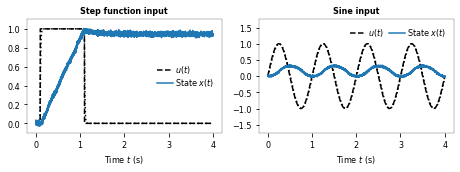

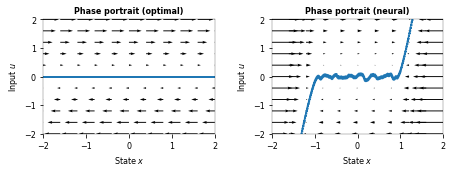

In [183]:
# Integrator

A = np.array([
    [0.0]
], dtype=float)

B = np.array([
    [1.0]
], dtype=float)

tau = 100e-3
Ap = tau * A + np.eye(A.shape[0])
Bp = tau * B

fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))

# Step function
data = simulate_dynamics(Piecewise({
    0.1: 1.0,
    1.1: 0.0,}),
    lambda u: Bp @ u,
    lambda x: Ap @ x, T=4,tau=tau,
    get_decoders=True)
plot_dynamics(*data[0:3], range_=(-0.1, 1.1), ax=axs[0], ncol=1)
axs[0].set_xlabel('Time $t$ (s)')
axs[0].set_title('Step function input')

# Sine input
plot_dynamics(*simulate_dynamics(
    lambda t: np.sin(2.0 * np.pi * t),
    lambda u: Bp @ u,
    lambda x: Ap @ x, T=4,tau=tau), ax=axs[1])
axs[1].set_xlabel('Time $t$ (s)')
axs[1].set_title('Sine input')

fig.tight_layout()
fig.savefig('../example_integrator.pdf', bbox_inches='tight', transparent=True)

# Phase portraits optimal and target
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))

plot_phase_portrait(lambda x, u: (u, 0), ax=axs[0], symbolic_eqilibria=True)
axs[0].set_title('Phase portrait (optimal)')

ens_data = data[3]
con_data = data[4]
f = get_feedback_dynamics_for_ens(ens_data, con_data)
plot_phase_portrait(lambda x, u: (u + (f(x) - x) / tau, 0), ax=axs[1], symbolic_eqilibria=False)
axs[1].set_title('Phase portrait (neural)')

fig.tight_layout()
fig.savefig('../example_integrator_phases.pdf', bbox_inches='tight', transparent=True)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/andreas/.local/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: No contour levels were found within the data range.


(11, 11, 2)
(300, 300, 2)


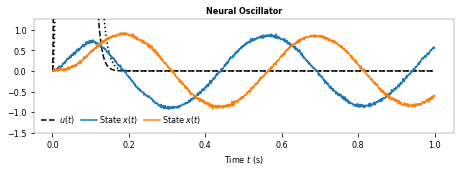

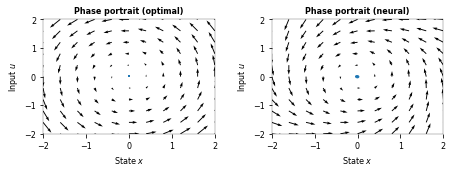

In [188]:
# Oscillator
with nengo.Network() as model:
    tau = 100e-3
    omega = 2.0 * (2.0 * np.pi)

    A = np.array([
        [0.0, -omega],
        [omega, 0.0]
    ], dtype=float)

    B = np.array([
        [1.0],
        [0.0],
    ], dtype=float)

    Ap = tau * A + np.eye(A.shape[0])
    Bp = tau * B

    nd_stim = nengo.Node(Piecewise({
        0.0: 10.0,
        0.1: 0.0,
    }))
    ens_x = nengo.Ensemble(
        n_neurons=100, dimensions=A.shape[0]
    )

    con_f = nengo.Connection(ens_x, ens_x, transform=Ap, synapse=tau)
    nengo.Connection(nd_stim, ens_x, transform=Bp, synapse=tau)

    p_x = nengo.Probe(ens_x, synapse=10e-3)
    p_u = nengo.Probe(nd_stim, synapse=10e-3)

with nengo.Simulator(model) as sim:
    sim.run(1.0)
    ts = sim.trange()
    us = sim.data[p_u]
    xs = sim.data[p_x]
    ens_data = sim.data[ens_x]
    con_data = sim.data[con_f]
    
fig, ax = plt.subplots(figsize=(6.5, 2.5))
plot_dynamics(ts, us, xs, ncol=3, range_=(-1.5, 1.25), ax=ax)
ax.set_xlabel('Time $t$ (s)')
ax.set_title('Neural Oscillator')


fig.tight_layout()
fig.savefig('../example_oscillator.pdf', bbox_inches='tight', transparent=True)


# Phase portraits optimal and target
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))
f = get_feedback_dynamics_for_ens(ens_data, con_data, dim=2)
def phi(x, u):
    xs = np.concatenate((x[:, :, None], u[:, :, None]), axis=2)
    res = (f(xs) - xs) / tau
    return res[:, :, 0], res[:, :, 1]

# Phase portraits optimal and target (for slides)
plot_phase_portrait(lambda x, u: (-4.0 * np.pi * u, 4.0 * np.pi * x), ax=axs[0], symbolic_eqilibria=False)
axs[0].set_title('Phase portrait (optimal)')

plot_phase_portrait(phi, ax=axs[1], symbolic_eqilibria=False, th=1e-1)
axs[1].set_title('Phase portrait (neural)')

fig.tight_layout()
fig.savefig('../example_oscillator_phases.pdf', bbox_inches='tight', transparent=True)


In [211]:
with nengo.Network() as model:
    tau = 0.1
    sigma = 10
    beta = 8.0/3
    rho = 28

    def feedback(x):
        dx0 = -sigma * x[0] + sigma * x[1]
        dx1 = -x[0] * x[2] - x[1]
        dx2 = x[0] * x[1] - beta * (x[2] + rho) - rho
        return [dx0 * tau + x[0], 
                dx1 * tau + x[1], 
                dx2 * tau + x[2]]

    with model:
        lorenz = nengo.Ensemble(2000, dimensions=3, radius=60)

        nengo.Connection(lorenz, lorenz, function=feedback, synapse=tau)

        lorenz_p = nengo.Probe(lorenz, synapse=tau)

    sim = nengo.Simulator(model)
    sim.run(14)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

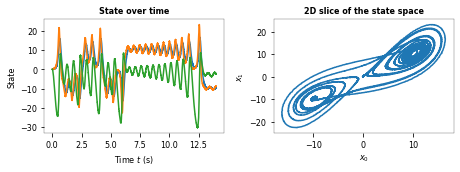

In [212]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))
axs[0].plot(sim.trange(), sim.data[lorenz_p]);
axs[0].set_xlabel('Time $t$ (s)')
axs[0].set_ylabel('State')
axs[0].set_title("State over time")
       
axs[1].plot(sim.data[lorenz_p][:,0],sim.data[lorenz_p][:,1]);
axs[1].set_xlabel('$x_0$')
axs[1].set_ylabel('$x_1$')
axs[1].set_title("2D slice of the state space")

fig.tight_layout()
fig.savefig("../example_lorentz.pdf", bbox_inches='tight', transparent=True)

In [213]:
with nengo.Network() as model:

    tau = 0.02
    r=4

    def feedback(x):    
        return [-tau*r*x[1]+x[0], tau*r*x[0]+x[1]]

    def heart_shape(x):
        theta = np.arctan2(x[1], x[0])
        r = 2 - 2 * np.sin(theta) + np.sin(theta)*np.sqrt(np.abs(np.cos(theta)))/(np.sin(theta)+1.4)
        return -r*np.cos(theta), r*np.sin(theta)

    with model:
        stim = nengo.Node(lambda t: [.5,.5] if t<.02 else [0,0])

        heart_osc = nengo.Ensemble(1000, dimensions=2)
        heart = nengo.Ensemble(100, dimensions=2, radius=4)

        nengo.Connection(stim, heart_osc)
        nengo.Connection(heart_osc, heart_osc, function=feedback, synapse=tau)
        nengo.Connection(heart_osc, heart, function=heart_shape, synapse=tau)

        heart_p = nengo.Probe(heart, synapse=tau)

    sim = nengo.Simulator(model)
    sim.run(4)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

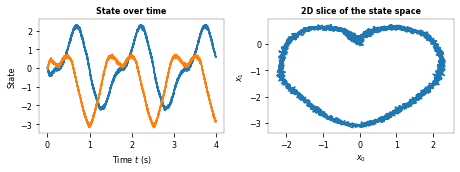

In [214]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))
axs[0].plot(sim.trange(), sim.data[heart_p]);
axs[0].set_xlabel('Time $t$ (s)')
axs[0].set_ylabel('State')
axs[0].set_title("State over time")
       
axs[1].plot(sim.data[heart_p][:,0],sim.data[heart_p][:,1]);
axs[1].set_xlabel('$x_0$')
axs[1].set_ylabel('$x_1$')
axs[1].set_title("2D slice of the state space")

fig.tight_layout()
fig.savefig("../example_heart.pdf", bbox_inches='tight', transparent=True)

In [215]:
with nengo.Network() as model:
    tau = 0.1
    tau_eye = 2.0

    stim = nengo.Node(Piecewise({.3:1, .6:0 }))
    velocity = nengo.Ensemble(100, dimensions=1)
    position = nengo.Ensemble(200, dimensions=1)
    
    def feedback(x):
        return (-tau/tau_eye + 1)*x
    
    conn = nengo.Connection(stim, velocity)
    conn = nengo.Connection(velocity, position, transform=tau, synapse=tau)
    conn = nengo.Connection(position, position, function=feedback, synapse=tau)

    stim_p = nengo.Probe(stim)
    position_p = nengo.Probe(position, synapse=.01)
    velocity_p = nengo.Probe(velocity, synapse=.01)
    
sim = nengo.Simulator(model)
sim.run(5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

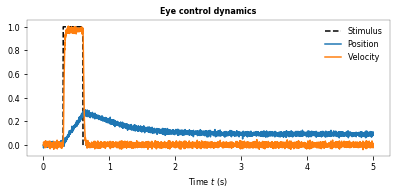

In [209]:
fig, ax = plt.subplots(figsize=(6.5, 2.5))
ax.plot(sim.trange(), sim.data[stim_p], "k--", label = "Stimulus")
ax.plot(sim.trange(), sim.data[position_p], label = "Position")
ax.plot(sim.trange(), sim.data[velocity_p], label = "Velocity")
ax.set_xlabel("Time $t$ (s)")
ax.legend(loc="best");
ax.set_title("Eye control dynamics")

fig.savefig("../example_eye_control.pdf", bbox_inches='tight', transparent=True)